In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter

from sqlalchemy import create_engine
import psycopg2


## Read Data

In [6]:
data_df = pd.read_csv('Data/indexProcessed.csv')

In [7]:
# Read indexProcessed.csv
df = pd.read_csv('Data/indexProcessed.csv')
df.dtypes

Index         object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
CloseUSD     float64
dtype: object

In [8]:
# Read indexInfo.csv
df_ref = pd.read_csv('Data/indexInfo.csv')
df_ref.dtypes

Region      object
Exchange    object
Index       object
Currency    object
dtype: object

In [91]:
# Merged DF 
Merged_df = pd.merge(df_ref,df, how='inner')
Merged_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007
...,...,...,...,...,...,...,...,...,...,...,...,...
104219,South Africa,Johannesburg Stock Exchange,J203.JO,ZAR,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,South Africa,Johannesburg Stock Exchange,J203.JO,ZAR,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,South Africa,Johannesburg Stock Exchange,J203.JO,ZAR,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,South Africa,Johannesburg Stock Exchange,J203.JO,ZAR,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


In [92]:
# Dataframe for NYA

df_NYA = Merged_df[Merged_df['Index'] == 'NYA']
df_NYA

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00,528.690002
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007
...,...,...,...,...,...,...,...,...,...,...,...,...
13942,United States,New York Stock Exchange,NYA,USD,2021-05-24,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450
13943,United States,New York Stock Exchange,NYA,USD,2021-05-25,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450
13944,United States,New York Stock Exchange,NYA,USD,2021-05-26,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940
13945,United States,New York Stock Exchange,NYA,USD,2021-05-27,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09,16531.949220


## Create Target 

In [93]:
# Find delta of today's close price from yesterday's close price 

df_NYA['Delta'] = df_NYA['Close'].diff()
df_NYA

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00,528.690002,NaN
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022,-1.479980
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027,0.630005
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995,3.279968
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007,0.950012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13942,United States,New York Stock Exchange,NYA,USD,2021-05-24,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450,89.689450
13943,United States,New York Stock Exchange,NYA,USD,2021-05-25,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450,-74.500000
13944,United States,New York Stock Exchange,NYA,USD,2021-05-26,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940,61.771490
13945,United States,New York Stock Exchange,NYA,USD,2021-05-27,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09,16531.949220,79.988280


In [94]:
#  Add traget column to dataframe

df_NYA['Target'] = np.where(df_NYA['Delta']>=0, 'Up', 'Down')
df_NYA

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Target
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00,528.690002,NaN,Down
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022,-1.479980,Down
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027,0.630005,Up
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995,3.279968,Up
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007,0.950012,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13942,United States,New York Stock Exchange,NYA,USD,2021-05-24,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450,89.689450,Up
13943,United States,New York Stock Exchange,NYA,USD,2021-05-25,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450,-74.500000,Down
13944,United States,New York Stock Exchange,NYA,USD,2021-05-26,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940,61.771490,Up
13945,United States,New York Stock Exchange,NYA,USD,2021-05-27,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09,16531.949220,79.988280,Up


In [95]:
df_NYA = df_NYA.dropna(how="any")
df_NYA

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Target
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022,-1.479980,Down
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027,0.630005,Up
3,United States,New York Stock Exchange,NYA,USD,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995,3.279968,Up
4,United States,New York Stock Exchange,NYA,USD,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007,0.950012,Up
5,United States,New York Stock Exchange,NYA,USD,1966-01-07,532.599976,532.599976,532.599976,532.599976,532.599976,0.000000e+00,532.599976,0.529969,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13942,United States,New York Stock Exchange,NYA,USD,2021-05-24,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450,89.689450,Up
13943,United States,New York Stock Exchange,NYA,USD,2021-05-25,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450,-74.500000,Down
13944,United States,New York Stock Exchange,NYA,USD,2021-05-26,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940,61.771490,Up
13945,United States,New York Stock Exchange,NYA,USD,2021-05-27,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09,16531.949220,79.988280,Up


In [96]:
list(df_NYA)

['Region',
 'Exchange',
 'Index',
 'Currency',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'CloseUSD',
 'Delta',
 'Target']

Below we are creating a baseline model

# LogisticRegression 

In [97]:
from sklearn.linear_model import LogisticRegression

y = df_NYA['Target']
X = df_NYA[['Open',
 'High',
 'Low',
 'Close',
 'Adj Close'
           ]]

clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)

clf.predict_proba(X)


clf.score(X, y)


0.65481141545963

# Split the Data into Training and Testing

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split (X,
                                                     y,
                                                     random_state =1,
                                                     stratify = y)

X_train.shape
Counter(y_train)

Counter({'Up': 5580, 'Down': 4879})

# Balanced Random Forest Classifier

In [99]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier.
model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 

# Fitting the model
model = model.fit(X_train, y_train)

In [100]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.614647150570679

In [101]:
len(y_pred)

3487

In [102]:
# create an acutal and predicted df
RFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
RFC_pred_df

,Prediction,Actual
5403,Down,Up
1746,Down,Down
8985,Down,Down
4186,Down,Up
13791,Up,Down
...,...,...
10821,Down,Down
1366,Up,Down
12692,Up,Up
2448,Up,Down


In [111]:
# merge test predictions with intitial df for comparison
RFC_df = RFC_pred_df.merge(df_NYA, left_index=True, right_index=True)
RFC_df = RFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'Delta', 'Target', 'Actual','Prediction']]
RFC_df.drop('Target', axis=1, inplace=True)
RFC_df['Date'] =  pd.to_datetime(RFC_df['Date'])
RFC_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Actual,Prediction
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,14.169922,Up,Down
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,-5.600037,Down,Down
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,-117.790039,Down,Down
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,6.559997,Up,Down
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,-5.910160,Down,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,United States,New York Stock Exchange,NYA,USD,2008-12-29,5538.189941,5564.819824,5470.899902,5534.640137,5534.640137,3.323430e+09,5534.640137,-3.549804,Down,Down
1366,United States,New York Stock Exchange,NYA,USD,1971-07-14,581.869995,581.869995,581.869995,581.869995,581.869995,0.000000e+00,581.869995,-0.950012,Down,Up
12692,United States,New York Stock Exchange,NYA,USD,2016-06-06,10508.500000,10568.849610,10508.500000,10554.820310,10554.820310,3.442020e+09,10554.820310,66.879880,Up,Up
2448,United States,New York Stock Exchange,NYA,USD,1975-10-24,502.989990,502.989990,502.989990,502.989990,502.989990,0.000000e+00,502.989990,-7.190003,Down,Up


In [59]:
# export as csv
RFC_df.to_csv('Data/Random_Forest_Predictions.csv')

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
RFC_plot_df = RFC_df
RFC_plot_df['Encoded'] = RFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
RFC_plot_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Actual,Prediction,Encoded
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,14.169922,Up,Down,0
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,-5.600037,Down,Down,0
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,-117.790039,Down,Down,0
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,6.559997,Up,Down,0
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,-5.910160,Down,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,United States,New York Stock Exchange,NYA,USD,2008-12-29,5538.189941,5564.819824,5470.899902,5534.640137,5534.640137,3.323430e+09,5534.640137,-3.549804,Down,Down,0
1366,United States,New York Stock Exchange,NYA,USD,1971-07-14,581.869995,581.869995,581.869995,581.869995,581.869995,0.000000e+00,581.869995,-0.950012,Down,Up,1
12692,United States,New York Stock Exchange,NYA,USD,2016-06-06,10508.500000,10568.849610,10508.500000,10554.820310,10554.820310,3.442020e+09,10554.820310,66.879880,Up,Up,1
2448,United States,New York Stock Exchange,NYA,USD,1975-10-24,502.989990,502.989990,502.989990,502.989990,502.989990,0.000000e+00,502.989990,-7.190003,Down,Up,1


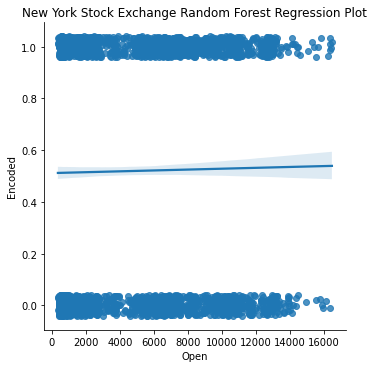

In [122]:
RFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=RFC_plot_df,
           logistic=True, y_jitter=.04);
RFC_reg_plot.set(title = 'New York Stock Exchange Random Forest Regression Plot')


In [123]:
RFC_reg_plot.savefig('Plots/NYA_Random_Forest_Regression.png')

In [60]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1572,   55],
       [1265,  595]])

In [61]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.55      0.97      0.32      0.70      0.56      0.33      1627
         Up       0.92      0.32      0.97      0.47      0.56      0.29      1860

avg / total       0.75      0.62      0.66      0.58      0.56      0.31      3487



In [62]:
# List the features sorted in descending order by feature importance
sorted(zip(model.feature_importances_,X.columns), reverse=True)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# SMOTE Oversampling

In [78]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample( X_train, y_train)



In [79]:
Counter(y_resampled)

Counter({'Up': 5580, 'Down': 5580})

In [80]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [81]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.6430439624349849

In [82]:
# create an acutal and predicted df
SRFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
SRFC_pred_df

,Prediction,Actual
5403,Down,Up
1746,Down,Down
8985,Down,Down
4186,Down,Up
13791,Up,Down
...,...,...
10821,Down,Down
1366,Down,Down
12692,Up,Up
2448,Down,Down


In [83]:
# merge test predictions with intitial df for comparison
SRFC_df = SRFC_pred_df.merge(df_NYA, left_index=True, right_index=True)
SRFC_df = SRFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'Delta', 'Target', 'Actual','Prediction']]
SRFC_df.drop('Target', axis=1, inplace=True)
SRFC_df['Date'] =  pd.to_datetime(SRFC_df['Date'])
SRFC_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Actual,Prediction
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,14.169922,Up,Down
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,-5.600037,Down,Down
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,-117.790039,Down,Down
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,6.559997,Up,Down
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,-5.910160,Down,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,United States,New York Stock Exchange,NYA,USD,2008-12-29,5538.189941,5564.819824,5470.899902,5534.640137,5534.640137,3.323430e+09,5534.640137,-3.549804,Down,Down
1366,United States,New York Stock Exchange,NYA,USD,1971-07-14,581.869995,581.869995,581.869995,581.869995,581.869995,0.000000e+00,581.869995,-0.950012,Down,Down
12692,United States,New York Stock Exchange,NYA,USD,2016-06-06,10508.500000,10568.849610,10508.500000,10554.820310,10554.820310,3.442020e+09,10554.820310,66.879880,Up,Up
2448,United States,New York Stock Exchange,NYA,USD,1975-10-24,502.989990,502.989990,502.989990,502.989990,502.989990,0.000000e+00,502.989990,-7.190003,Down,Down


In [84]:
# export as csv
SRFC_df.to_csv('Data/SMOTE_Random_Forest_Predictions.csv')

In [124]:
SRFC_plot_df = SRFC_df
SRFC_plot_df['Encoded'] = SRFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
SRFC_plot_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Actual,Prediction,Encoded
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,14.169922,Up,Down,0
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,-5.600037,Down,Down,0
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,-117.790039,Down,Down,0
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,6.559997,Up,Down,0
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,-5.910160,Down,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,United States,New York Stock Exchange,NYA,USD,2008-12-29,5538.189941,5564.819824,5470.899902,5534.640137,5534.640137,3.323430e+09,5534.640137,-3.549804,Down,Down,0
1366,United States,New York Stock Exchange,NYA,USD,1971-07-14,581.869995,581.869995,581.869995,581.869995,581.869995,0.000000e+00,581.869995,-0.950012,Down,Down,0
12692,United States,New York Stock Exchange,NYA,USD,2016-06-06,10508.500000,10568.849610,10508.500000,10554.820310,10554.820310,3.442020e+09,10554.820310,66.879880,Up,Up,1
2448,United States,New York Stock Exchange,NYA,USD,1975-10-24,502.989990,502.989990,502.989990,502.989990,502.989990,0.000000e+00,502.989990,-7.190003,Down,Down,0


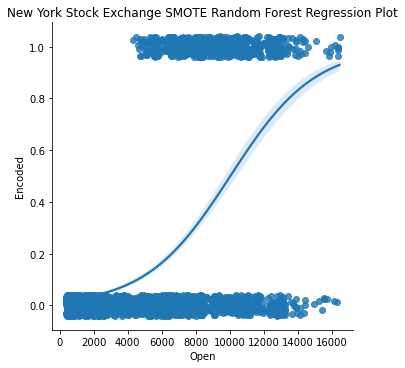

In [125]:
SRFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=SRFC_plot_df,
           logistic=True, y_jitter=.04);
SRFC_reg_plot.set(title = 'New York Stock Exchange SMOTE Random Forest Regression Plot')

In [126]:
SRFC_reg_plot.savefig('Plots/NYA_SMOTE_Random_Forest_Regression.png')

In [70]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1572,   55],
       [1265,  595]])

In [71]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.55      0.97      0.32      0.70      0.56      0.33      1627
         Up       0.92      0.32      0.97      0.47      0.56      0.29      1860

avg / total       0.75      0.62      0.66      0.58      0.56      0.31      3487



# Undersampling

In [85]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'Down': 4879, 'Up': 4879})

In [86]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [87]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.6428136421013674

In [88]:
# create an acutal and predicted df
URFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
URFC_pred_df

,Prediction,Actual
5403,Down,Up
1746,Down,Down
8985,Down,Down
4186,Down,Up
13791,Up,Down
...,...,...
10821,Down,Down
1366,Down,Down
12692,Up,Up
2448,Down,Down


In [89]:
# merge test predictions with intitial df for comparison
URFC_df = URFC_pred_df.merge(df_NYA, left_index=True, right_index=True)
URFC_df = URFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'Delta', 'Target', 'Actual','Prediction']]
URFC_df.drop('Target', axis=1, inplace=True)
URFC_df['Date'] =  pd.to_datetime(URFC_df['Date'])
URFC_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Actual,Prediction
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,14.169922,Up,Down
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,-5.600037,Down,Down
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,-117.790039,Down,Down
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,6.559997,Up,Down
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,-5.910160,Down,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,United States,New York Stock Exchange,NYA,USD,2008-12-29,5538.189941,5564.819824,5470.899902,5534.640137,5534.640137,3.323430e+09,5534.640137,-3.549804,Down,Down
1366,United States,New York Stock Exchange,NYA,USD,1971-07-14,581.869995,581.869995,581.869995,581.869995,581.869995,0.000000e+00,581.869995,-0.950012,Down,Down
12692,United States,New York Stock Exchange,NYA,USD,2016-06-06,10508.500000,10568.849610,10508.500000,10554.820310,10554.820310,3.442020e+09,10554.820310,66.879880,Up,Up
2448,United States,New York Stock Exchange,NYA,USD,1975-10-24,502.989990,502.989990,502.989990,502.989990,502.989990,0.000000e+00,502.989990,-7.190003,Down,Down


In [90]:
# export as csv
URFC_df.to_csv('Data/Undersampling_Random_Forest_Predictions.csv')

In [127]:
URFC_plot_df = URFC_df
URFC_plot_df['Encoded'] = URFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
URFC_plot_df

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Delta,Actual,Prediction,Encoded
5403,United States,New York Stock Exchange,NYA,USD,1987-07-07,1828.089966,1828.089966,1828.089966,1828.089966,1828.089966,0.000000e+00,1828.089966,14.169922,Up,Down,0
1746,United States,New York Stock Exchange,NYA,USD,1973-01-15,681.159973,681.159973,681.159973,681.159973,681.159973,0.000000e+00,681.159973,-5.600037,Down,Down,0
8985,United States,New York Stock Exchange,NYA,USD,2001-09-07,5986.529785,5986.529785,5986.529785,5986.529785,5986.529785,1.424300e+09,5986.529785,-117.790039,Down,Down,0
4186,United States,New York Stock Exchange,NYA,USD,1982-09-13,740.479980,740.479980,740.479980,740.479980,740.479980,0.000000e+00,740.479980,6.559997,Up,Down,0
13791,United States,New York Stock Exchange,NYA,USD,2020-10-15,12974.129880,13148.700200,12960.980470,13137.250000,13137.250000,3.717640e+09,13137.250000,-5.910160,Down,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,United States,New York Stock Exchange,NYA,USD,2008-12-29,5538.189941,5564.819824,5470.899902,5534.640137,5534.640137,3.323430e+09,5534.640137,-3.549804,Down,Down,0
1366,United States,New York Stock Exchange,NYA,USD,1971-07-14,581.869995,581.869995,581.869995,581.869995,581.869995,0.000000e+00,581.869995,-0.950012,Down,Down,0
12692,United States,New York Stock Exchange,NYA,USD,2016-06-06,10508.500000,10568.849610,10508.500000,10554.820310,10554.820310,3.442020e+09,10554.820310,66.879880,Up,Up,1
2448,United States,New York Stock Exchange,NYA,USD,1975-10-24,502.989990,502.989990,502.989990,502.989990,502.989990,0.000000e+00,502.989990,-7.190003,Down,Down,0


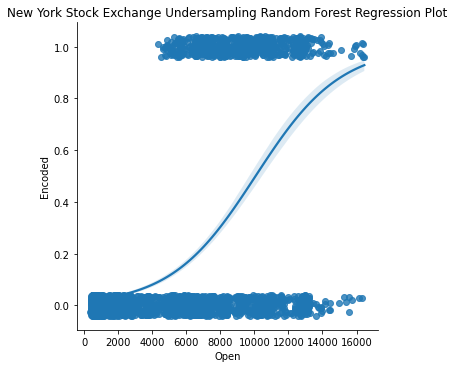

In [129]:
URFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=URFC_plot_df,
           logistic=True, y_jitter=.04);
URFC_reg_plot.set(title = 'New York Stock Exchange Undersampling Random Forest Regression Plot')

In [130]:
SRFC_reg_plot.savefig('Plots/NYA_Undersampling_Random_Forest_Regression.png')

In [95]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1573,   54],
       [1267,  593]], dtype=int64)

In [96]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.55      0.97      0.32      0.70      0.56      0.33      1627
         Up       0.92      0.32      0.97      0.47      0.56      0.29      1860

avg / total       0.75      0.62      0.66      0.58      0.56      0.31      3487

